# This is a notebook to demonstrate k-space to image space conversion with MRI


It includes the code used to produce the images in the main notebook.

https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

# be able to..
1) transform between k space and not k-space  $\checkmark$

2) select region of kspace to transform and see resulting image $\checkmark$

2) watch as image is constructed from added points in kspace (like CT reconstruction) with the plane waves overlaid (and path/points are shown in k space as it's added on $\checkmark$

4) observe the path (epi or radial etc) and how image is formed $\checkmark$

5) How only a little more than half of ks-space is needed $\checkmark$

5) phase and frequency encoding? or is that too advanced?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import csv
import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr
from scipy.special import stdtr
import csv
import pandas as pd

import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

import matplotlib.image as mpimg


from tkinter import *
from tkinter import ttk

from mpl_toolkits.mplot3d import Axes3D

import pydicom as dicom


In [2]:
%matplotlib

Using matplotlib backend: MacOSX


# Show Image

$FOV_{img} = 1361 x 1361$ \
$\Delta x = 1$ 

In [54]:
name = 'Sagittal'
ds = dicom.dcmread('data/' +name +'.dcm')
img = ds.pixel_array
#img = #img[530:-530,:-1,0]
#print(np.shape(img))

#img = img[1:,33:-33]
pl.imshow(img,cmap = 'gray')
pl.show()

fov_img = 256

# Get k-space through FFT of Image
$FOV_{kspace} = \frac{1}{\Delta x} = 1$\
$\Delta k_x = \frac{1}{FOV_{img}} = \frac{1}{1361} $ 

In [55]:
ft = np.fft.ifftshift(img)
ft = np.fft.fft2(ft)
kspace = np.fft.fftshift(ft) #moves zero frequency component to center
kx_ax = np.fft.fftfreq(np.shape(img)[0],1) #goes from -.5 to +.5 frequency
print('min kx:',min(kx_ax),'\nmax kx:', max(kx_ax),'\nDelta kx = ',1/fov_img)
pl.imshow(np.abs(kspace),vmin = 0,vmax = 4000,extent = [-.5, .5, -.5, .5],cmap = 'gray')
pl.colorbar()
pl.show()

with open('data/'+ name + '_FullImages.pickle','wb') as handle: 
    pickle.dump([img,kspace],handle)

min kx: -0.5 
max kx: 0.49609375 
Delta kx =  0.00390625


# Get image back with iFFT of k-space

In [43]:
ift = np.fft.fftshift(kspace)
ift = np.fft.ifft2(ift)
iimg = np.fft.ifftshift(ift)
pl.imshow(np.abs(iimg),cmap = 'gray')
pl.show()


# Now get ROI and crop k-space
give it a center, and x and y dimensions. will make a rectangle

In [44]:
def DrawRect(kspace,fov_img,center,xdim,ydim): #takes it in idx, not frequency values
    kspace_cropped = kspace
    minx = center[0] - xdim
    maxx = center[0] + xdim
    miny = center[1] - ydim
    maxy = center[1] + ydim
    for j in range(len(kspace)):
        for k in range(len(kspace)):
            if j < minx or j > maxx or k < miny or k > maxy : 
                #print(kspace_cropped[k,j])
                kspace_cropped[k,j] = 0 #k is y, j is x. 
                #print(kspace_cropped[k,j])
            #else:
                #print('not')
    return kspace_cropped

In [45]:
fig, (ax1, ax2) = pl.subplots(1,2)

rect_kspace = DrawRect(kspace,fov_img,[round(fov_img/2),round(fov_img/2)],50,50)
ax1.imshow(np.abs(rect_kspace),vmin = 0,vmax = 4000,extent = [-.5, .5, -.5, .5],cmap = 'gray')

ift = np.fft.fftshift(rect_kspace)
ift = np.fft.ifft2(ift)
cropped_iimg = np.fft.ifftshift(ift)
ax2.imshow(np.abs(cropped_iimg),cmap = 'gray')
pl.show()


# Now watch live reconstruction of the image from k-space

# do as spiral.... 


In [46]:
# assumed odd and equal nummber of nx and ny
# makes list of indices to do a spiral
# see 8/20/22 notes
def Spiral(nx):
    SpiralArray_x = [] 
    SpiralArray_y = []
    center = int(nx/2)
    # add center as first 
    x,y = center,center
    SpiralArray_x.append(x)
    SpiralArray_y.append(y)
    for j in np.arange(1,nx,2): #from 0 to the number of nx there is in steps of 2
        # do x = x+1 and then y = y-1 a certain number of times
        for k in range(j):
            x = x+1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
        for m in range(j):
            y = y-1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
        for p in range(j+1):
            x = x-1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
        for q in range(j+1):
            y = y+1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
    for v in range(nx-1):
        x = x+1
        SpiralArray_x.append(x)
        SpiralArray_y.append(y)
        
    SpiralArray = np.vstack((SpiralArray_x,SpiralArray_y))
    
    return SpiralArray

#this will avoid doubling with mirroring (see 8/29/22)
def cropped_spiral(nx):
    SpiralArray_x = [] 
    SpiralArray_y = []
    center = int(nx/2)
    # add center as first 
    x,y = center,center
    SpiralArray_x.append(x)
    SpiralArray_y.append(y)
    for j in range(int(nx/2)):
        y = center + j
        x = center
        SpiralArray_x.append(x)
        SpiralArray_y.append(y)
        for k in range(j):
            x = x+1 
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
        for m in range(j*2):
            y = y - 1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
        for p in range(j-1):
            x = x-1
            SpiralArray_x.append(x)
            SpiralArray_y.append(y)
    
    SpiralArray = np.vstack((SpiralArray_x,SpiralArray_y))
    
    return SpiralArray


In [47]:
cropped_kspace = kspace[round(fov_img/2)-60:round(fov_img/2)+61,round(fov_img/2)-60:round(fov_img/2)+61]

#fig, (ax1,ax2,ax3) = pl.subplots(1,3)
SpiralAcquisition = cropped_spiral(len(cropped_kspace)) #get spiral acuisition points
center = int(len(cropped_kspace)/2)

spiraling_k = np.zeros(np.shape(cropped_kspace))
superimpose_img = np.zeros(np.shape(cropped_kspace))

#ax3.imshow(img,cmap='gray')
#ax3.set_title('Final image')


one_counter = np.arange(0,20,1)
ten_counter = np.arange(20,len(SpiralAcquisition[0]/2),100) #every 10, from 20 pixel on to half way
fifty_counter = np.arange(len(SpiralAcquisition[0])/2,len(SpiralAcquisition[0]),200) #from every 150 pixels to end
steps = np.concatenate((one_counter,ten_counter,fifty_counter))

stacked_iffts = np.zeros((len(cropped_kspace[0]),len(cropped_kspace[1]),len(steps)))
stacked_kspace = np.zeros((len(cropped_kspace[0]),len(cropped_kspace[1]),len(steps)))
counter = 0
for j in np.arange(0,len(SpiralAcquisition[0])): #for each point in this spiral, i.e. all of k-space
    # get mask that gets that point and it's corresponding buddy 
    mask = np.zeros(np.shape(cropped_kspace))
    
    kx = SpiralAcquisition[0][j]
    ky = SpiralAcquisition[1][j]
    mask[kx,ky]  = 1
    # now get it reflected across the origin as well 
    dkx = center - kx
    dky = center - ky
    
    mirror_kx = center + dkx 
    mirror_ky = center + dky
    mask[mirror_kx, mirror_ky] = 1
        
    # now get those points in k-space
    kspace_point = cropped_kspace*mask 
    
    #show k-space growing
    spiraling_k = spiraling_k + kspace_point # and add it to show the growing k-space
    #ax1.imshow(np.abs(spiraling_k),vmin = 0,vmax = 6000,extent = [-.5, .5, -.5, .5],cmap = 'gray')
    #ax1.set_title('k-space used so far')
    
    
    # now get inverse ft of that point only every 10
    if j in steps:
        stacked_kspace[:,:,counter] = np.abs(spiraling_k)
        ift = np.fft.fftshift(spiraling_k)
        ift = np.fft.ifft2(ift)
        iimg = np.fft.ifftshift(ift) # want to save this! 
        stacked_iffts[:,:,counter] = np.abs(iimg)
        counter = counter + 1
    
    # now begin to sum up these individual contributions
    #superimpose_img = superimpose_img + np.real(iimg)
    #ax2.imshow(np.abs(iimg),cmap = 'gray')
    #ax2.set_title('Image being produced')
    
    
    #pl.pause(.001)
    
    
    
    
    
with open('data/'+ name + '_superposition.pickle','wb') as handle: 
    pickle.dump(stacked_iffts,handle)
with open('data/' + name + '_superposition_kspace.pickle','wb') as handle: 
    pickle.dump(stacked_kspace,handle)

    
    

In [48]:
cropped_kspace = kspace[round(fov_img/2)-60:round(fov_img/2)+61,round(fov_img/2)-60:round(fov_img/2)+61]

#fig, (ax1,ax2,ax3) = pl.subplots(1,3)
SpiralAcquisition = cropped_spiral(len(cropped_kspace)) #get spiral acuisition points
center = int(len(cropped_kspace)/2)

spiraling_k = np.zeros(np.shape(cropped_kspace))
superimpose_img = np.zeros(np.shape(cropped_kspace))

stacked_maskiffts = np.zeros((len(cropped_kspace[0]),len(cropped_kspace[1]),len(steps)))

counter = 0
for i in steps: #for each point in this spiral, i.e. all of k-space
    # get mask that gets that point and it's corresponding buddy 
    j = int(i)
    mask = np.zeros(np.shape(cropped_kspace))
    
    kx = SpiralAcquisition[0][j]
    ky = SpiralAcquisition[1][j]
    mask[kx,ky]  = 1
    # now get it reflected across the origin as well 
    dkx = center - kx
    dky = center - ky
    
    mirror_kx = center + dkx 
    mirror_ky = center + dky
    mask[mirror_kx, mirror_ky] = 1
        
    # now get those points in k-space
    kspace_point = cropped_kspace*mask 

    
    # now get inverse ft of that point
    ift = np.fft.fftshift(kspace_point)
    ift = np.fft.ifft2(ift)
    iimg = np.fft.ifftshift(ift) # want to save this! 
    stacked_maskiffts[:,:,counter] = np.abs(iimg)
    counter = counter + 1
    
    
    
    #pl.pause(.001)
    
    
    
    
    
with open('data/'+ name + '_superposition_masks.pickle','wb') as handle: 
    pickle.dump(stacked_maskiffts,handle)

    
    

# a bit too computationally expensive, so gonna do it once (hopefully) and save it in a pickle file... 

In [49]:

ds = dicom.dcmread('data/' + name + '.dcm')
img = ds.pixel_array

fov_img = 256

with open('data/'+name + '_superposition.pickle','rb') as handle1:
    stack_image = pickle.load(handle1)
with open('data/'+ name +'_superposition_masks.pickle','rb') as handle2:
    stack_waves = pickle.load(handle2)
with open('data/'+ name + '_superposition_kspace.pickle','rb') as handle3:
    stack_kspace = pickle.load(handle3)
    
fig, (ax1, ax2, ax3,ax4) = pl.subplots(1,4)
ax4.imshow(img,cmap = 'gray')
ax4.set_title('Final Image')
for i in np.arange(0,np.shape(stack_image)[2],4):
    ax1.imshow(stack_kspace[:,:,i],vmin = 0,vmax = 6000,extent = [-.5, .5, -.5, .5],cmap = 'gray')
    ax1.set_title('k-space')
    ax2.imshow(stack_waves[:,:,i],cmap = 'gray')
    ax2.set_title('planar\nwaves')
    ax3.imshow(stack_image[:,:,i],cmap = 'gray')
    ax3.set_title('Image\nForming')
    pl.pause(.1)

# Code for plots in RunMe.ipynb

In [ ]:
x = np.linspace(0, 1, 1000) #from 0 to 1, sampling rate of 1/1000
wave1 = np.sin(2*np.pi*5*x) #frequency of 5
ft_sin1 = np.fft.fft(wave1)
ft_sin1 = np.fft.fftshift(ft_sin1)
ft_freq = np.linspace(-500,500,1000) #kmax = 1/2Deltax, Delta kx = 1/FOVx

# Set up subplots
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = pl.subplots(3,2)

# plot wave 1 with 5 cycles per second
ax1.plot(x,wave1)
ax1.set_title('5 Hz')
ax2.plot(ft_freq,abs(ft_sin1))
ax2.set_title('FT of 5 Hz')
ax2.set_xlim([-10,10])

# plot wave 2 with 7 cycles per second
wave2 = np.sin(2*np.pi*7*x)
ft_sin2 = np.fft.fft(wave2)
ft_sin2 = np.fft.fftshift(ft_sin2)
ax3.plot(x,wave2,color = 'red')
ax3.set_title('7 Hz')
ax4.plot(ft_freq,abs(ft_sin2),color = 'red')
ax4.set_title('FT of 7 Hz')
ax4.set_xlim([-10,10])

# plot sum of the two
wavesum = wave1+wave2
ft_sinsum = np.fft.fft(wavesum)
ft_sinsum = np.fft.fftshift(ft_sinsum)
ax5.plot(x,wave1+wave2,color = 'purple')
ax5.set_title('5 Hz + 7 Hz')
ax6.plot(ft_freq,abs(ft_sinsum),color = 'purple')
ax6.set_title('FT of 7 Hz + 5 Hz')
ax6.set_xlim([-10,10])


fig.tight_layout()
pl.savefig('data/Fig1.png',dpi = 100)

with open('data/Fig1_1dWaves.pickle','wb') as handle: 
    pickle.dump([wave1,ft_sin1,wave2,ft_sin2,wavesum,ft_sinsum],handle)

In [4]:
pl.close()
fig, ((ax1, ax2),(ax3,ax4)) = pl.subplots(2,2)

x = np.linspace(0, 1, 100)
ft_freq = np.linspace(-50,50,100)
X, Y = np.meshgrid(x, x)
img = np.sin(2 * np.pi * X *5) 
ax1.imshow(img,cmap = 'gray',extent = [0,1,0,1])
ax1.set_title('2d planar wave')
ax2.plot(x,img[51])
ax2.set_title('Cross section of 2d planar wave')

#so this has wavelength of 30
# pixel size of 3

ft = np.fft.fft2(img)
kspace = np.fft.fftshift(ft) #moves zero frequency component to center
ax3.imshow(np.abs(kspace),cmap = 'gray',extent = [-50,50,-50,50])
ax3.set_title('Fourier Transform of 2d planar wave')
ax4.plot(ft_freq,np.abs(kspace)[50])
ax4.set_title('Cross section of Fourier Transform')
fig.tight_layout()
pl.show()


#pl.savefig('data/Fig2.png',dpi = 100)

with open('data/Fig2_2dWaves.pickle','wb') as handle: 
    pickle.dump([img,kspace],handle)


In [7]:
fig, (ax1, ax2) = pl.subplots(1,2)
angles = np.linspace(0,np.pi,15)
ax1.set_title('Planar Wave')
ax2.set_title('FT of Planar Wave')
kspace_rotating = np.zeros((len(img[0]),len(img[0]),15))
image_rotating =np.zeros((len(img[0]),len(img[0]),15))
count = 0
for tilt in angles:
    #phi being the tilt angle
    img = np.sin(2*np.pi*(X*np.cos(tilt) + Y*np.sin(tilt)) * 5)
    ax1.imshow(img,cmap = 'gray')
    ft = np.fft.fft2(img)
    kspace = np.fft.fftshift(ft) #moves zero frequency component to center
    ax2.imshow(np.abs(kspace),cmap = 'gray')
    
    image_rotating[:,:,count] = img
    kspace_rotating[:,:,count] = kspace
    count = count+1
    pl.pause(.5)
    
with open('data/Fig3_Rotating.pickle','wb') as handle: 
    pickle.dump([image_rotating,kspace_rotating],handle)
    
    

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [9]:
fig, (ax1, ax2) = pl.subplots(1,2)
angles = np.linspace(0,np.pi,20)
freqs = np.linspace(5,33,20)
ax1.set_title('Planar Wave')
ax2.set_title('FT of Planar Wave')
x = np.linspace(0, 1, 100)
ft_freq = np.linspace(-50,50,100)
X, Y = np.meshgrid(x, x)
kspace_rotateincrease = np.zeros((len(img[0]),len(img[0]),20))
image_rotateincrease =np.zeros((len(img[0]),len(img[0]),20))
count = 0
for j in range(len(angles)):
    #phi being the tilt angle
    img = np.sin(2*np.pi*(X*np.cos(angles[j]) + Y*np.sin(angles[j])) *freqs[j])
    ax1.imshow(img,cmap = 'gray')
    ft = np.fft.fft2(img)
    kspace = np.fft.fftshift(ft) #moves zero frequency component to center
    ax2.imshow(np.abs(kspace),cmap = 'gray')

    image_rotateincrease[:,:,count] = img
    kspace_rotateincrease[:,:,count] = kspace
    
    count = count+1
    pl.pause(.5)
    

with open('data/Fig4_RotatingIncreasing.pickle','wb') as handle: 
    pickle.dump([image_rotateincrease,kspace_rotateincrease],handle)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


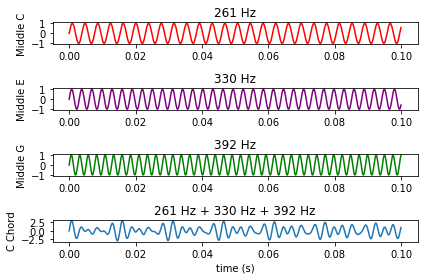

Text(0.5, 1.0, 'C Chord Sound Wave')

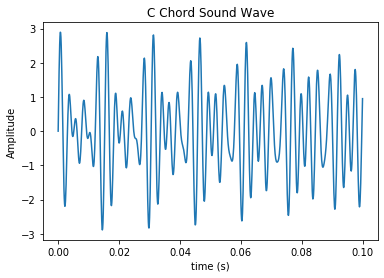

In [25]:
x = np.linspace(0, .1, 1000) #from 0 to 1, sampling rate of 1/1000
ft_freq = np.linspace(-500,500,1000) #kmax = 1/2Deltax, Delta kx = 1/FOVx

# Set up subplots
fig, (ax1,ax2,ax3,ax4) = pl.subplots(4,1)
wave1 = np.sin(2*np.pi*261*x) #frequency of middle C
wave2 = np.sin(2*np.pi*329*x) #frequency of E
wave3 = np.sin(2*np.pi*392*x) #frequency of middle C


ax1.plot(x,wave1,color = 'red')
ax1.set_ylabel('Middle C')
ax1.set_title('261 Hz')

ax2.plot(x,wave2,color = 'purple')
ax2.set_ylabel('Middle E')
ax2.set_title('330 Hz')

ax3.plot(x,wave3,color = 'green')
ax3.set_ylabel('Middle G')
ax3.set_title('392 Hz')

ax4.plot(x,wave1+wave2+wave3)
ax4.set_ylabel('C Chord')
ax4.set_xlabel('time (s)')
ax4.set_title('261 Hz + 330 Hz + 392 Hz')
fig.tight_layout()
pl.show()

pl.plot(x,wave1+wave2+wave3)
pl.xlabel('time (s)')
pl.ylabel('Amplitude')
pl.title('C Chord Sound Wave')
